# Graph Neural Networks for SMall Molecule Regression
_by David Holmberg (August 2023)_
#### Dataset
For this exercise we will use the same dataset of aqueous solubility of 1142 diverse chemical compounds.

#### Modelling comparisons
1. Compare the results of linear regression to those of Graph Neural Networks

#### Aims
* Introduce the concept of Graph Neural Networks
* Introduce PyTorch code for GNNs


## Load packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Pytorch and Pytorch Geometric
import torch as tch
import torch.nn as nn
import torch.optim as optim

from torch_geometric.nn import GCNConv, GATConv, summary as gsummary, global_mean_pool, global_max_pool
from torch_geometric.data import Data#, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import dropout_adj

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski


# Helper libraries
from torchsummary import summary as asummary
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = ""
device = tch.device("cuda" if tch.cuda.is_available() else "cpu")
# device = tch.device('cuda')

RDKit WARNING: [16:03:01] Enabling RDKit 2019.09.1 jupyter extensions
[16:03:01] Enabling RDKit 2019.09.1 jupyter extensions


## functions
Run these cells to have access to the necessary functions for the lab. Highly encouraged that you read through it and understand, though not necessary for the aims of this lab.

In [2]:


def plot_history(train_losses, val_losses, model_name):
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(train_losses)
    ax.plot(val_losses)
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    ax = fig.add_subplot(122)
    ax.plot(np.log(train_losses))
    ax.plot(np.log(val_losses))
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()
#Set morgan to 3 or 4 and nBits to 1024
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    return list(fp.ToBitString())

def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
    return mol

def read_smiles_data(path_data):
    df = pd.read_csv(path_data, sep=',')
    df['fingerprint'] = df['SMILES'].apply(smiles_to_fingerprint)
    df['fingerprint'] = df['fingerprint'].apply(lambda x: [int(bit) for bit in x])
    df['fingerprint'] = df['fingerprint'].apply(lambda x: np.array(x))
    df['mol'] = df['SMILES'].apply(smiles_to_mol)
    return df

def is_hydrogen_donor(atomic_num, hybridization):
    return int((atomic_num == 8 or atomic_num == 7) and (hybridization == 3 or hybridization == 2))

def is_polar_bond(atom1_num, atom2_num, electronegativity):
    en1 = electronegativity.get(atom1_num, None)
    en2 = electronegativity.get(atom2_num, None)
    if en1 is None or en2 is None:
        return 0  # Unknown electronegativity, consider as non-polar
    return int(abs(en1 - en2) > 0.4)

def electroneg():
    return {
    1: 2.20,  # H
    3: 0.98,  # Li
    4: 1.57,  # Be
    5: 2.04,  # B
    6: 2.55,  # C
    7: 3.04,  # N
    8: 3.44,  # O
    9: 3.98,  # F
    11: 0.93, # Na
    12: 1.31, # Mg
    13: 1.61, # Al
    14: 1.90, # Si
    15: 2.19, # P
    16: 2.58, # S
    17: 3.16, # Cl
    19: 0.82, # K
    20: 1.00, # Ca
    22: 1.54, # Ti
    24: 1.66, # Cr
    25: 1.55, # Mn
    26: 1.83, # Fe
    27: 1.88, # Co
    28: 1.91, # Ni
    29: 1.90, # Cu
    30: 1.65, # Zn
    35: 2.96, # Br
    53: 2.66, # I
}

def weights_init(m):
    if isinstance(m, (GCNConv, GATConv)):
        nn.init.xavier_uniform_(m.weight.data)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)

def make_pyg(row):
    # Create node features
    mol = row['mol']
    pauling = electroneg()
    atom_num = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    atom_hyb = [int(atom.GetHybridization()) for atom in mol.GetAtoms()]
    atom_deg = [atom.GetDegree() for atom in mol.GetAtoms()]
    atom_arom = [int(atom.GetIsAromatic()) for atom in mol.GetAtoms()]  # Aromaticity
    atom_hydrogens = [atom.GetTotalNumHs() for atom in mol.GetAtoms()]  # Number of hydrogens
    atom_h_donor = [is_hydrogen_donor(num, hyb) for num, hyb in zip(atom_num, atom_hyb)]
    atom_charge = [atom.GetFormalCharge() for atom in mol.GetAtoms()]  # Formal charge
    atom_chiral_tag = [int(atom.GetChiralTag()) for atom in mol.GetAtoms()]  # Chirality
    atom_val = [atom.GetExplicitValence() for atom in mol.GetAtoms()]
    atom_mass = [atom.GetMass() for atom in mol.GetAtoms()]
    atom_pauling = [pauling.get(num, 0) for num in atom_num]
    
    x1 = tch.tensor(atom_num, dtype=tch.float).view(-1, 1)
    x2 = tch.tensor(atom_hyb, dtype=tch.float).view(-1, 1)
    x3 = tch.tensor(atom_deg, dtype=tch.float).view(-1, 1)
    x4 = tch.tensor(atom_arom, dtype=tch.float).view(-1, 1)
    x5 = tch.tensor(atom_hydrogens, dtype=tch.float).view(-1, 1)
    x6 = tch.tensor(atom_h_donor, dtype=tch.float).view(-1, 1)
    x7 = tch.tensor(atom_charge, dtype=tch.float).view(-1, 1)
    x8 = tch.tensor(atom_chiral_tag, dtype=tch.float).view(-1, 1)
    x9 = tch.tensor(atom_val, dtype=tch.float).view(-1, 1)
    x10 = tch.tensor(atom_mass, dtype=tch.float).view(-1, 1)
    x11 = tch.tensor(atom_pauling, dtype=tch.float).view(-1, 1)
    
    y = tch.tensor(row['measured.log.solubility.mol.L.'], dtype=tch.float).view(-1, 1)
    x = tch.cat([x1
                 , x2
                 , x3
                 , x4
                 , x5
                 , x6
                 , x7
                 , x8
                 , x9
                 , x10
                 , x11]
                 , dim=1)
    # Create edge features (connectivity)
    edge_indices = []
    edge_features = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.append((i, j))
        bond_type = bond.GetBondTypeAsDouble()
        is_conjugated = int(bond.GetIsConjugated())  # Conjugation
        is_in_ring = int(bond.IsInRing())  # Ring membership
        bond_stereo = int(bond.GetStereo())  # Stereo configuration
        bond_polarity = is_polar_bond(atom_num[i], atom_num[j], pauling)
        edge_features.append([bond_type
                              , is_conjugated
                              , is_in_ring
                              , bond_stereo
                              , bond_polarity])
    edge_index = tch.tensor(edge_indices, dtype=tch.long).t().contiguous()
    edge_attr = tch.tensor(edge_features, dtype=tch.float)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.smiles = row['SMILES']
    return data


### Training Functions for Neural Networks
This cell defines the training methods for the neural networks you will use later in this notebook. WHile they are ready to use, you should read them carefully to understand what parameters you will need to use, and how.

In [3]:
def fitGNN(gnn1_model, t_loader, v_loader, num_epochs, batch_size, optimizer, criterion):
    train_losses = []
    val_losses = []
    pbar = tqdm(range(num_epochs), desc="Epochs")
    pbar.reset()
    pbar_t = tqdm(total=len(t_loader), desc="Training Batch:", leave=False)
    pbar_v = tqdm(total=len(v_loader), desc="validation Batch:", leave=False)
    for epoch in range(num_epochs):
        # Training Phase
        gnn1_model.train()
        train_loss_items = []
        pbar_t.reset()
        pbar_v.reset()
        for batch in t_loader:
            batch.to(device)
            optimizer.zero_grad()
            # Use Batch Data object in forward pass
            outputs = gnn1_model(batch.x.float(), batch.edge_index, batch.batch)
            loss = criterion(outputs, batch.y)
            loss.backward()
            optimizer.step()
            train_loss_items.append(loss.item())
            pbar_t.update()
        avg_train_loss = sum(train_loss_items) / len(train_loss_items)
        train_losses.append(avg_train_loss)
        # Validation Phase (assuming you have a separate validation loader)
        gnn1_model.eval()
        val_loss_items = []
        with tch.no_grad():
            for val_batch in v_loader:
                val_batch.to(device)
                val_outputs = gnn1_model(val_batch.x.float(), val_batch.edge_index, val_batch.batch)
                val_loss = criterion(val_outputs, val_batch.y)
                val_loss_items.append(val_loss.item())
                pbar_v.update()

        avg_val_loss = sum(val_loss_items) / len(val_loss_items)
        val_losses.append(avg_val_loss)
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Val Loss: {avg_val_loss:.4f}')
        pbar.update(1)
        pbar.set_postfix({"Training Loss": avg_train_loss, "Validation Loss": avg_val_loss})
    return gnn1_model, train_losses, val_losses

In [4]:
df = read_smiles_data('data/solubility.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()


,Compound.ID,measured.log.solubility.mol.L.,ESOL.predicted.log.solubility.mol.L.,SMILES,fingerprint,mol
0,"2,3,6-Trichlorophenol",-2.64,-3.572,Oc1c(Cl)ccc(Cl)c1Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f12b291a220>
1,tetrachloroguaiacol,-4.02,-4.299,COc1c(O)c(Cl)c(Cl)c(Cl)c1Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f12b28ba160>
2,3-Methyl-3-heptanol,-1.60,-2.017,CCCCC(C)(O)CC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f12b29154c0>
3,cycloheximide,-1.13,-1.532,CC1CC(C)C(=O)C(C1)C(O)CC2CC(=O)NC(=O)C2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f12b28a02e0>
4,Acridine,-3.67,-3.846,c3ccc2nc1ccccc1cc2c3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f12b29161c0>


In [5]:
len(df['fingerprint'].iloc[0])

1024

In [6]:
# scaler = StandardScaler()
# df['measured.log.solubility.mol.L.'] = scaler.fit_transform(df[['measured.log.solubility.mol.L.']])
data_pyg = df.apply(make_pyg, axis=1)
data_pyg = data_pyg[data_pyg.apply(lambda x: len(x.edge_index.shape) != 1)]
data_pyg.reset_index(drop=True, inplace=True)


In [7]:

df_train = df.sample(frac=0.8)
df_test = df.drop(df_train.index)

df_train.reset_index(drop=True)
df_test.reset_index(drop=True)
X_train, y_train = df_train['fingerprint'].tolist(), df_train['measured.log.solubility.mol.L.'].tolist()
X_test, y_test = df_test['fingerprint'].tolist(), df_test['measured.log.solubility.mol.L.'].tolist()


n_train = int(len(data_pyg) * 0.8) 
indices = np.arange(n_train)
data_train = data_pyg[indices[:n_train]]
data_train.reset_index(drop=True, inplace=True)
data_test = data_pyg[~data_pyg.isin(data_train)]
data_test.reset_index(drop=True, inplace=True)




#### Random Forest Regressor

In [8]:
RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)
RF_mse = mean_squared_error(y_test, RF_pred)
print('Random Forest Regressor: MSE = ' + str(np.round(RF_mse, 3)))

Random Forest Regressor: MSE = 1.392


#### Support Vector Regressor

In [9]:
SV_model = SVR()
SV_model.fit(X_train, y_train)
SV_pred = SV_model.predict(X_test)
SV_mse = mean_squared_error(y_test, SV_pred)
print('Support Vector Regressor: MSE = ' + str(np.round(SV_mse, 3)))

Support Vector Regressor: MSE = 1.687


#### GNNs


In [10]:
# Initialize the GNN1 model
# input_dim = data_train.iloc[5].x.size(1)
input_dim = data_train[5].x.size(1)
print('Input Dimensions: ', input_dim)
#Loss and optimizer|
num_epochs = 1000
batch_size = 64
weight_decay = 1e-4
criterion = nn.MSELoss()
t_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
v_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)


    

Input Dimensions:  11


In [11]:
class GNN1(nn.Module):
    def __init__(self, input_dim):
        super(GNN1, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 64)
        self.conv4 = GCNConv(64, 32)
        self.conv5 = GCNConv(32, 16)
        self.fc3 = nn.Linear(16, 1)  # Output layer with 1 node
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index, batch):
        # x, edge_index = data.x, data.edge_index
        x = self.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv4(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv5(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.fc3(x)
        return x



In [12]:
gnn1_model = GNN1(input_dim)
gnn1_model = gnn1_model.to(device)
optimizer = optim.Adam(gnn1_model.parameters(), lr=0.0001,weight_decay= weight_decay)  # Adjust learning rate as needed
gnn1_model, train_losses, val_losses = fitGNN(gnn1_model, t_loader, v_loader, num_epochs, batch_size, optimizer, criterion)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Batch::   0%|          | 0/15 [00:00<?, ?it/s]

validation Batch::   0%|          | 0/4 [00:00<?, ?it/s]

GNN1 Regression: MSE = 7.585


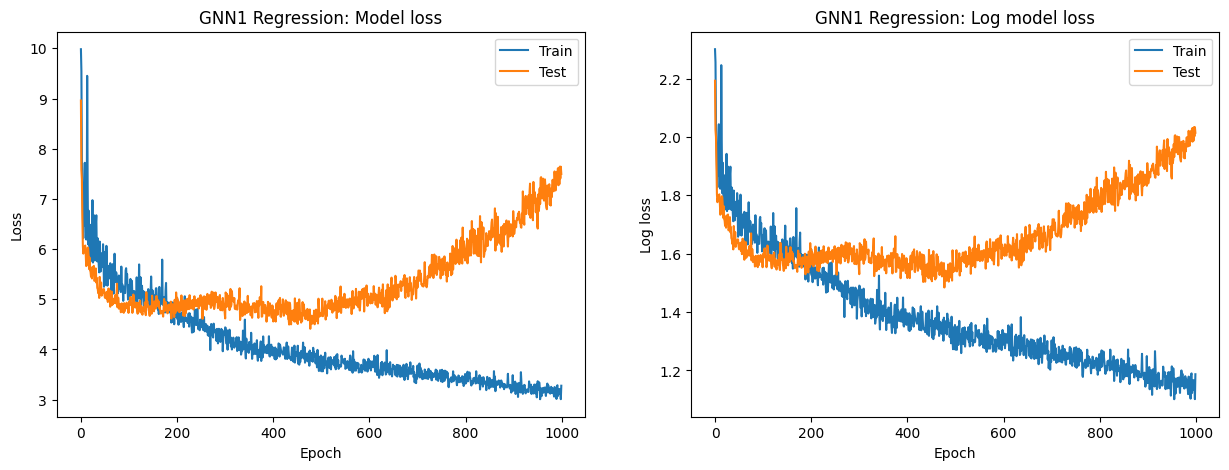

In [13]:
gnn1_model.eval()
all_preds = []
all_labels = []
with tch.no_grad():
    for v_batch in v_loader:
        v_batch.to(device)
        test_outputs = gnn1_model(v_batch.x.float(), v_batch.edge_index, v_batch.batch)
        all_preds.extend(test_outputs.tolist())
        all_labels.extend(v_batch.y.tolist())
all_preds_tensor = tch.tensor(all_preds)
all_labels_tensor = tch.tensor(all_labels)
gnn1_mse = mean_squared_error(all_labels_tensor, all_preds_tensor)

print(f'GNN1 Regression: MSE = {gnn1_mse:.3f}')
plot_history(train_losses, val_losses, 'GNN1 Regression')

In [14]:

class GNN2(nn.Module):
    def __init__(self, input_dim):
        super(GNN2, self).__init__()
        self.conv1 = GATConv(input_dim, 64, heads=2, concat=True)  # Two attention heads
        self.conv2 = GATConv(128, 32, heads=2, concat=True)  # Two attention heads
        self.conv3 = GATConv(64, 16, heads=2, concat=True)  # Two attention heads
        self.conv4 = GATConv(32, 8, heads=2, concat=True)  # Two attention heads
        self.conv5 = GATConv(16, 16, heads=1, concat=True)  # Single attention head
        self.fc3 = nn.Linear(16, 1)  # Output layer with 1 node
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, edge_index, batch):
        x = self.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv4(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv5(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.fc3(x)
        return x

In [15]:

gnn2_model = GNN2(input_dim).to(device)
optimizer = optim.Adam(gnn2_model.parameters()
                       , lr=0.0005
                       , weight_decay= weight_decay
                       )  # Adjust learning rate as needed
gnn2_model, train_losses, val_losses = fitGNN(gnn2_model, t_loader, v_loader, num_epochs, batch_size, optimizer, criterion)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Batch::   0%|          | 0/15 [00:00<?, ?it/s]

validation Batch::   0%|          | 0/4 [00:00<?, ?it/s]

GNN2 Regression: MSE = 3.995


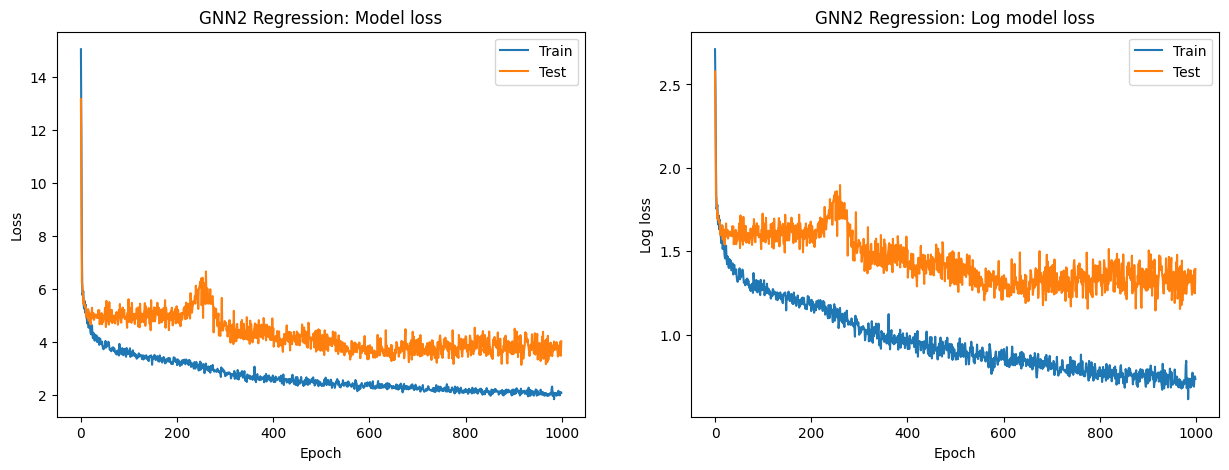

In [16]:
gnn2_model.eval()
all_preds = []
all_labels = []
with tch.no_grad():
    for v_batch in v_loader:
        v_batch.to(device)
        test_outputs = gnn2_model(v_batch.x, v_batch.edge_index, v_batch.batch)
        all_preds.extend(test_outputs.tolist())
        all_labels.extend(v_batch.y.tolist())
all_preds_tensor = tch.tensor(all_preds)
all_labels_tensor = tch.tensor(all_labels)
gnn2_mse = mean_squared_error(all_labels_tensor, all_preds_tensor)

print(f'GNN2 Regression: MSE = {gnn2_mse:.3f}')
plot_history(train_losses, val_losses, 'GNN2 Regression')

In [17]:
class GNN3(nn.Module):
    def __init__(self, input_dim):
        super(GNN3, self).__init__()
        self.conv1 = GATConv(input_dim, 64, heads=2, concat=True)  # Single attention head
        self.conv2 = GATConv(128, 32, heads=2, concat=True)  # Single attention head
        self.conv3 = GATConv(64, 16, heads=2, concat=True)  # Single attention head
        self.conv4 = GATConv(32, 8, heads=2, concat=True)  # Single attention head
        self.conv5 = GATConv(16, 16, heads=1, concat=True)  # Single attention head
        self.fc3 = nn.Linear(16, 1)  # Output layer with 1 node
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, edge_index, batch):
        x = self.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv4(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv5(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.fc3(x)
        return x

In [18]:
# Initialize the GNN1 model
num_epochs = 6000
gnn3_model = GNN3(input_dim).to(device)
optimizer = optim.Adam(gnn3_model.parameters()
                       , lr=0.0005
                       , weight_decay= weight_decay
                       )  # Adjust learning rate as needed
gnn3_model, train_losses, val_losses = fitGNN(gnn3_model, t_loader, v_loader, num_epochs, batch_size, optimizer, criterion)

Epochs:   0%|          | 0/6000 [00:00<?, ?it/s]

Training Batch::   0%|          | 0/15 [00:00<?, ?it/s]

validation Batch::   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
gnn3_model.eval()
all_preds = []
all_labels = []
with tch.no_grad():
    for v_batch in v_loader:
        v_batch.to(device)
        test_outputs = gnn3_model(v_batch.x, v_batch.edge_index, v_batch.batch)
        all_preds.extend(test_outputs.tolist())
        all_labels.extend(v_batch.y.tolist())
all_preds_tensor = tch.tensor(all_preds)
all_labels_tensor = tch.tensor(all_labels)
gnn3_mse = mean_squared_error(all_labels_tensor, all_preds_tensor)

print(f'GNN3 Regression: MSE = {gnn3_mse:.3f}')
plot_history(train_losses, val_losses, 'GNN3 Regression')

In [ ]:
plt.bar(["SVM", "Random Forest", "GNN1", "GNN2", "GNN3"], [SV_mse, RF_mse, gnn1_mse, gnn2_mse, gnn3_mse])
plt.ylabel("MSE")
plt.title("Results")